# Data Exploration and Visualization of NOM Data in NMDC (FT ICR-MS)
This notebook identifies NOM samples in NMDC, filters those samples based on quality control metrics and analyzes the molecular composition of chosen samples via Van Krevelen plots.

In [2]:
import requests
from io import StringIO
import nom_functions as func
import pandas as pd
import matplotlib.pyplot as plt
import statistics as stats
import itertools
import seaborn as sns
import numpy as np
from matplotlib.patches import Patch
from matplotlib.colors import LinearSegmentedColormap

### Gather IDs for processed NOM results by filtering for data objects of type FT ICR-MS

Using the python requests library and the [NMDC metadata endpoint](https://api.microbiomedata.org/docs#/metadata/list_from_collection_nmdcschema__collection_name__get), we can filter the collection `data_object_set` by type “FT ICR-MS Analysis Results” to gather processed NOM results. More information regarding the API can be found [here](https://github.com/microbiomedata/NMDC_documentation/blob/main/docs/howto_guides/api_gui.md)

In [3]:
# pull all NOM data objects
processed_nom=func.get_next_results(collection='data_object_set',\
                       filter='{"data_object_type":{"$regex": "FT ICR-MS Analysis Results"}}',\
                        max_page_size=100,fields='id,md5_checksum,url')

# clarify names
for dataobject in processed_nom:
    dataobject["processed_nom_id"] = dataobject.pop("id")
    dataobject["processed_nom_md5_checksum"] = dataobject.pop("md5_checksum")
    dataobject["processed_nom_url"] = dataobject.pop("url")

# convert to df
processed_nom_df = func.convert_df(processed_nom)
processed_nom_df

,processed_nom_id,processed_nom_md5_checksum,processed_nom_url
0,nmdc:dobj-11-00dewm52,2a532dca15798e470103ebd752a0937f,https://nmdcdemo.emsl.pnnl.gov/nom/1000soils/r...
1,nmdc:dobj-11-00wm3313,3ce562ac512457ea54bdda05a4f01ede,https://nmdcdemo.emsl.pnnl.gov/nom/1000soils/r...
2,nmdc:dobj-11-01kye625,38930c28eae561bc807bd01823f04167,https://nmdcdemo.emsl.pnnl.gov/nom/1000soils/r...
3,nmdc:dobj-11-02trja88,e6bafa5fabbebfb0061aa2587e223979,https://nmdcdemo.emsl.pnnl.gov/nom/grow/result...
4,nmdc:dobj-11-0312n668,20a5193d5fb54bf2a54c54b6f95a099d,https://nmdcdemo.emsl.pnnl.gov/nom/1000soils/r...
...,...,...,...
2542,nmdc:dobj-13-zrp1qw41,98b97b78fff542b66e72f4b3f792d80f,https://nmdcdemo.emsl.pnnl.gov/nom/results/SBR...
2543,nmdc:dobj-13-zsqpnm92,3e9e19910edb209d211d9f915e36b8cb,https://nmdcdemo.emsl.pnnl.gov/nom/results/Bro...
2544,nmdc:dobj-13-zvnmsp76,aec0521d6a36a440e41052f8eadc0d1d,https://nmdcdemo.emsl.pnnl.gov/nom/results/Ung...
2545,nmdc:dobj-13-zvzx2462,9f0d52cc46d247b8d2ba12d5842b9fb6,https://nmdcdemo.emsl.pnnl.gov/nom/results/Bro...


### Continue traversing the NMDC schema by using a list of identifiers from the previous API call to query the next collection using the [NMDC metadata endpoint](https://api.microbiomedata.org/docs#/metadata/list_from_collection_nmdcschema__collection_name__get)

Find the analysis records that produced these processed nom object IDs by matching object `ID` to the `has_output` slot in the collection `nom_analysis_activity_set`.

In [4]:
analysis_dataobj=func.get_id_results(
                                    newest_results=processed_nom,\
                                    id_field="processed_nom_id",\
                                    query_collection="nom_analysis_activity_set",\
                                    match_id_field="has_output",\
                                    query_fields="id,has_input,has_output")

# clarify names
for dataobject in analysis_dataobj:
    dataobject["analysis_id"] = dataobject.pop("id")
    dataobject["analysis_has_input"] = dataobject.pop("has_input")
    dataobject["analysis_has_output"] = dataobject.pop("has_output")

# convert to data frame
analysis_dataobj_df = func.convert_df(analysis_dataobj)
analysis_dataobj_df



,analysis_id,analysis_has_input,analysis_has_output
0,nmdc:wfnom-11-fwhgp651.1,[nmdc:dobj-11-hrqfj247],[nmdc:dobj-11-0dn7p856]
1,nmdc:wfnom-11-snvsmz18.1,[nmdc:dobj-11-esgqw196],[nmdc:dobj-11-0bmapy68]
2,nmdc:wfnom-11-ph9mfs20.1,[nmdc:dobj-11-sj597780],[nmdc:dobj-11-04v02904]
3,nmdc:wfnom-11-x8j6qc18.1,[nmdc:dobj-11-jjmn7962],[nmdc:dobj-11-1qhx4085]
4,nmdc:wfnom-11-479gvz55.1,[nmdc:dobj-11-rq95kp39],[nmdc:dobj-11-0cf8jk36]
...,...,...,...
2542,nmdc:wfnom-13-ycxczw19.1,[nmdc:dobj-13-w9czqg70],[nmdc:dobj-13-yasv1664]
2543,nmdc:wfnom-13-b2e44434.1,[nmdc:dobj-13-aef3pw71],[nmdc:dobj-13-ykh2yk18]
2544,nmdc:wfnom-13-eb5f8063.1,[nmdc:dobj-13-b28x6912],[nmdc:dobj-13-xstcrm22]
2545,nmdc:wfnom-13-k9tdtt72.1,[nmdc:dobj-13-g1wmqa90],[nmdc:dobj-13-zkgr9031]


Find the raw data objects used as input for these analysis records by matching the analysis record's `has_input` slot to the `ID` slot in the collection `data_object_set`.

In [5]:
raw_dataobj=func.get_id_results(
                                    newest_results=analysis_dataobj,\
                                    id_field="analysis_has_input",\
                                    query_collection="data_object_set",\
                                    match_id_field="id",\
                                    query_fields="id,name")
# clarify names
for dataobject in raw_dataobj:
    dataobject["raw_id"] = dataobject.pop("id")
    dataobject["raw_name"] = dataobject.pop("name")

raw_df = func.convert_df(raw_dataobj)

raw_df

,raw_id,raw_name
0,nmdc:dobj-11-04embv91,Lybrand_FT_62_W_23Aug19_Alder_Infuse_p3_1_01_4...
1,nmdc:dobj-11-04ny1n21,Lybrand_FT_36_C_30Aug19_Alder_Infuse_p05_1_01_...
2,nmdc:dobj-11-09p17z03,Lybrand_Permafrost_BOG_14_CHCl3_13Dec19_Alder_...
3,nmdc:dobj-11-0cmhqk17,WHONDRS_S19S_0059_ICR_1_43_Alder_Inf_13Sept19_...
4,nmdc:dobj-11-0rgvyp97,WHONDRS_S19S_R33_14Sept2020_Alder_Infuse_p15_1...
...,...,...
2542,nmdc:dobj-13-ww59kg97,output: Unground_SBR_Spring_2014_FC_S2_10-20_M...
2543,nmdc:dobj-13-ym2bx698,output: Unground_SBR_Spring_2014_FC_S2_00-10_H...
2544,nmdc:dobj-13-zazrqk87,output: Brodie_185_w_r1_01Feb19_HESI_neg
2545,nmdc:dobj-13-zjrg8w43,output: Brodie_184_H2O_11Mar19_R1_HESI_Neg


Find the omics processing records that produced these raw data objects by matching the data object's `ID` slot to the `has_output` slot in the collection `omics_processing_set`.

In [6]:
omicsprocess_dataobj=func.get_id_results(
                                    newest_results=raw_dataobj,\
                                    id_field="raw_id",\
                                    query_collection="omics_processing_set",\
                                    match_id_field="has_output",\
                                    query_fields="id,has_input,has_output")

# clarify names
for dataobject in omicsprocess_dataobj:
    dataobject["omicsprocess_id"] = dataobject.pop("id")
    dataobject["omicsprocess_has_output"] = dataobject.pop("has_output")
    dataobject["omicsprocess_has_input"] = dataobject.pop("has_input")
# convert to data frame
omicsprocess_dataobj_df = func.convert_df(omicsprocess_dataobj)
omicsprocess_dataobj_df


,omicsprocess_id,omicsprocess_has_output,omicsprocess_has_input
0,nmdc:omprc-11-adjx8k29,[nmdc:dobj-11-04embv91],[nmdc:bsm-11-ax989290]
1,nmdc:omprc-11-w1kvtj73,[nmdc:dobj-11-04ny1n21],[nmdc:bsm-11-qvtb2v69]
2,nmdc:omprc-11-rj3bqn04,[nmdc:dobj-11-09p17z03],[nmdc:bsm-11-6aqn1d84]
3,nmdc:omprc-11-a1szxs11,[nmdc:dobj-11-0cmhqk17],[nmdc:bsm-11-b7c2dc48]
4,nmdc:omprc-11-sc2gv291,[nmdc:dobj-11-0rgvyp97],[nmdc:bsm-11-m1cbn542]
...,...,...,...
2542,nmdc:omprc-13-agdd4h68,[nmdc:dobj-13-ww59kg97],[nmdc:bsm-13-ty597764]
2543,nmdc:omprc-13-820dfq84,[nmdc:dobj-13-ym2bx698],[nmdc:bsm-13-rrsd4804]
2544,nmdc:omprc-11-5y5txf92,[nmdc:dobj-13-zazrqk87],[nmdc:bsm-11-4sw8dr23]
2545,nmdc:omprc-11-077nww93,[nmdc:dobj-13-zjrg8w43],[nmdc:bsm-11-afgbs159]


Find the biosample data objects used as input for these omics processing records by matching the processing record's `has_input` slot to the `ID` slot in the collection `biosample_set`.

In [7]:
biosample_dataobj=func.get_id_results(
                                    newest_results=omicsprocess_dataobj,\
                                    id_field="omicsprocess_has_input",\
                                    query_collection="biosample_set",\
                                    match_id_field="id",\
                                    query_fields="id,name,part_of,analysis_type,geo_loc_name,env_medium")

# clarify names
for dataobject in biosample_dataobj:
    dataobject["biosample_id"] = dataobject.pop("id")

# convert to data frame
biosample_dataobj_df = func.convert_df(biosample_dataobj)

biosample_dataobj_df


,part_of,env_medium,geo_loc_name,analysis_type,name,biosample_id
0,[nmdc:sty-11-28tm5d36],{'has_raw_value': 'forest soil [ENVO:00002261]...,"{'has_raw_value': 'USA: Maryland, Winters Lane...","[metagenomics, natural organic matter]",1000 soils - WLUP_CoreB_TOP,nmdc:bsm-11-12esnc57
1,[nmdc:sty-11-db67n062],"{'has_raw_value': 'ENVO:00001998', 'term': {'i...","{'has_raw_value': 'USA: Alaska, Coldfoot'}",NaN,Lybrand_Permafrost_BOG_12_H2O,nmdc:bsm-11-17ag3b30
2,[nmdc:sty-11-8xdqsn54],"{'has_raw_value': 'ENVO:00001998', 'term': {'i...","{'has_raw_value': 'USA: ND, Stutsman'}",NaN,SanClements_NEON_HW_061,nmdc:bsm-11-26bgjj05
3,[nmdc:sty-11-28tm5d36],{'has_raw_value': 'agricultural soil [ENVO:000...,"{'has_raw_value': 'USA: Washington, Prosser No...","[metagenomics, natural organic matter]",1000 soils - PRS2_CoreB_TOP,nmdc:bsm-11-2d3eam48
4,[nmdc:sty-11-db67n062],"{'has_raw_value': 'ENVO:00001998', 'term': {'i...","{'has_raw_value': 'USA: Alaska, Healy'}",NaN,Lybrand_Permafrost_HE_02_CHCl3,nmdc:bsm-11-2n9dds87
...,...,...,...,...,...,...
2165,[nmdc:sty-11-aygzgv51],"{'has_raw_value': 'ENVO:01000017', 'term': {'i...","{'has_raw_value': 'USA: Columbia River, Washin...",NaN,Groundwater microbial communities from the Col...,nmdc:bsm-13-q0qxrf57
2166,[nmdc:sty-11-aygzgv51],"{'has_raw_value': 'ENVO:01000017', 'term': {'i...","{'has_raw_value': 'USA: Columbia River, Washin...",NaN,Groundwater microbial communities from the Col...,nmdc:bsm-13-rrsd4804
2167,[nmdc:sty-11-aygzgv51],"{'has_raw_value': 'ENVO:01000017', 'term': {'i...","{'has_raw_value': 'USA: Columbia River, Washin...",NaN,Groundwater microbial communities from the Col...,nmdc:bsm-13-tr7n0581
2168,[nmdc:sty-11-aygzgv51],"{'has_raw_value': 'ENVO:01000017', 'term': {'i...","{'has_raw_value': 'USA: Columbia River, Washin...",NaN,Groundwater microbial communities from the Col...,nmdc:bsm-13-ty597764


### Create final data frame of relevant metadata information

Extract environmental term for each biosample ID

In [8]:
biosample_dataobj_flat=pd.json_normalize(biosample_dataobj)
biosample_dataobj_flat_df=func.convert_df(biosample_dataobj_flat)

biosample_dataobj_flat_df['sample_type_manual']=""


biosample_dataobj_flat_df.loc[biosample_dataobj_flat_df['env_medium.term.id'].isin(["UBERON:0035118", "ENVO:00002003"]),'sample_type_manual'] = 'host'
biosample_dataobj_flat_df.loc[biosample_dataobj_flat_df['env_medium.term.id'].isin(["ENVO:00001998", "ENVO:00005774", "ENVO:00002258", "ENVO:00005778", "ENVO:00005802", 
                                "ENVO:02000059", "ENVO:00005741", "ENVO:01001841", "ENVO:00003082", "ENVO:00005800", "ENVO:01000018"]),'sample_type_manual'] = 'soil'
biosample_dataobj_flat_df.loc[biosample_dataobj_flat_df['env_medium.term.id'].isin(["ENVO:00002007", "ENVO:01000017", "ENVO:03605004", "ENVO:03605005"]),'sample_type_manual'] = 'sediment'
biosample_dataobj_flat_df.loc[biosample_dataobj_flat_df['env_medium.term.id'].isin(["ENVO:00002042", "ENVO:00002011", "ENVO:00002194", "ENVO:01001869", "ENVO:04000007"]),'sample_type_manual'] = 'water'
biosample_dataobj_flat_df.loc[biosample_dataobj_flat_df['env_medium.term.id'].isin(["ENVO:01000349", "ENVO:01001001", "ENVO:03605005"]),'sample_type_manual'] = 'plant'
biosample_dataobj_flat_df.loc[biosample_dataobj_flat_df['part_of'].isin(["nmdc:sty-11-pzmd0x14"]),'sample_type_manual'] = 'sediment'


biosample_dataobj_flat_df.loc[biosample_dataobj_flat_df['name'].str.contains('hizosphere',na=False),'sample_type_manual'] = 'plant'
biosample_dataobj_flat_df.loc[biosample_dataobj_flat_df['env_medium.term.id'].str.contains('PO:',na=False),'sample_type_manual']='plant'
biosample_dataobj_flat_df.loc[biosample_dataobj_flat_df['env_medium.term.name'].str.contains('soil',na=False),'sample_type_manual']='soil'
biosample_dataobj_flat_df.loc[biosample_dataobj_flat_df['env_medium.has_raw_value'].str.contains('soil',na=False),'sample_type_manual']='soil'
biosample_dataobj_flat_df.loc[biosample_dataobj_flat_df['env_medium.term.name'].str.contains('water',na=False),'sample_type_manual']='water'

biosample_dataobj_flat_df=biosample_dataobj_flat_df[['biosample_id','sample_type_manual']]

biosample_dataobj_flat_df

,biosample_id,sample_type_manual
0,nmdc:bsm-11-12esnc57,soil
1,nmdc:bsm-11-17ag3b30,soil
2,nmdc:bsm-11-26bgjj05,soil
3,nmdc:bsm-11-2d3eam48,soil
4,nmdc:bsm-11-2n9dds87,soil
...,...,...
2165,nmdc:bsm-13-q0qxrf57,sediment
2166,nmdc:bsm-13-rrsd4804,sediment
2167,nmdc:bsm-13-tr7n0581,sediment
2168,nmdc:bsm-13-ty597764,sediment


Create merged dataframe with results from schema traversal

In [9]:
#match all processed nom objects (via processed_nom_id) to analysis objects (via analysis_has_output) and expand lists has_input and has_output
processed_obj_to_analysis_df=func.merge_df(processed_nom_df,analysis_dataobj_df,"processed_nom_id","analysis_has_output",[],["analysis_has_input","analysis_has_output"])

#match raw data objects (via raw_id) to all_analysis_df (via analysis_has_input)
processed_obj_to_raw_df=func.merge_df(raw_df,processed_obj_to_analysis_df,"raw_id","analysis_has_input",[],[])

#match processed_obj_to_raw_df (via raw_id) to omics processing objects (via omicsprocess_has_output) and expand lists has_input and has_output
processed_obj_to_omicsprocess_df=func.merge_df(processed_obj_to_raw_df,omicsprocess_dataobj_df,"raw_id","omicsprocess_has_output",[],["omicsprocess_has_input","omicsprocess_has_output"])

#match biosample objects (via biosample_id) to processed_obj_to_omicsprocess_df (via omicsprocess_has_input)
merged_df=func.merge_df(biosample_dataobj_flat_df,processed_obj_to_omicsprocess_df,"biosample_id","omicsprocess_has_input",[],[])

merged_df

,biosample_id,sample_type_manual,raw_id,raw_name,processed_nom_id,processed_nom_md5_checksum,processed_nom_url,analysis_id,analysis_has_input,analysis_has_output,omicsprocess_id,omicsprocess_has_output,omicsprocess_has_input
0,nmdc:bsm-11-12esnc57,soil,nmdc:dobj-11-gdhnkg66,1000S_WLUP_FTMS_SPE_TOP_3_run2_Fir_28Apr22_300...,nmdc:dobj-11-0dyc2f79,9ace043441672422f7991411014ab9cb,https://nmdcdemo.emsl.pnnl.gov/nom/1000soils/r...,nmdc:wfnom-11-xnhh0t17.1,nmdc:dobj-11-gdhnkg66,nmdc:dobj-11-0dyc2f79,nmdc:omprc-11-wj8myx84,nmdc:dobj-11-gdhnkg66,nmdc:bsm-11-12esnc57
1,nmdc:bsm-11-12esnc57,soil,nmdc:dobj-11-vkheqz50,1000S_WLUP_FTMS_SPE_TOP_1_run2_Fir_22Apr22_300...,nmdc:dobj-11-07gsmc68,9363e9de79c39013257ddb4d967006b2,https://nmdcdemo.emsl.pnnl.gov/nom/1000soils/r...,nmdc:wfnom-11-r8x4ew73.1,nmdc:dobj-11-vkheqz50,nmdc:dobj-11-07gsmc68,nmdc:omprc-11-s2590964,nmdc:dobj-11-vkheqz50,nmdc:bsm-11-12esnc57
2,nmdc:bsm-11-12esnc57,soil,nmdc:dobj-11-qt6pmm77,1000S_WLUP_FTMS_SPE_TOP_3_run1_Fir_25Apr22_300...,nmdc:dobj-11-jj2r0a49,a502ec422a6f960972b759b143d8ad9c,https://nmdcdemo.emsl.pnnl.gov/nom/1000soils/r...,nmdc:wfnom-11-edr3rn40.1,nmdc:dobj-11-qt6pmm77,nmdc:dobj-11-jj2r0a49,nmdc:omprc-11-6mbfsz04,nmdc:dobj-11-qt6pmm77,nmdc:bsm-11-12esnc57
3,nmdc:bsm-11-12esnc57,soil,nmdc:dobj-11-z002ga43,1000S_WLUP_FTMS_SPE_TOP_2_run2_Fir_22Apr22_300...,nmdc:dobj-11-mmdwds36,dff9718e9428ec3aa77fed987deb637d,https://nmdcdemo.emsl.pnnl.gov/nom/1000soils/r...,nmdc:wfnom-11-zr24j979.1,nmdc:dobj-11-z002ga43,nmdc:dobj-11-mmdwds36,nmdc:omprc-11-6ejjgv07,nmdc:dobj-11-z002ga43,nmdc:bsm-11-12esnc57
4,nmdc:bsm-11-12esnc57,soil,nmdc:dobj-11-hdd01t09,1000S_WLUP_FTMS_SPE_TOP_1_run1_Fir_22Apr22_300...,nmdc:dobj-11-s42fww29,05cf8e9c0394dbdf80c3c6b89a4f3956,https://nmdcdemo.emsl.pnnl.gov/nom/1000soils/r...,nmdc:wfnom-11-befkpb58.1,nmdc:dobj-11-hdd01t09,nmdc:dobj-11-s42fww29,nmdc:omprc-11-mcataq54,nmdc:dobj-11-hdd01t09,nmdc:bsm-11-12esnc57
...,...,...,...,...,...,...,...,...,...,...,...,...,...
9621,nmdc:bsm-13-zxqyyz58,soil,nmdc:dobj-13-y1we6577,Rachael_21T_19-87_M_03Mar17_leopard_Infuse.raw,nmdc:dobj-13-jmv5e702,03a41ac4ad0381c412b3a55b06633cfa,https://nmdcdemo.emsl.pnnl.gov/nom/results/Rac...,nmdc:wfnom-13-s9ez8969.1,nmdc:dobj-13-y1we6577,nmdc:dobj-13-jmv5e702,nmdc:omprc-13-pbbt1t23,nmdc:dobj-13-y1we6577,nmdc:bsm-13-zxqyyz58
9622,nmdc:bsm-11-hbdmpd66,soil,nmdc:dobj-13-9za40068,output: Brodie_153_w_r2_29Jan19_HESI_neg,nmdc:dobj-13-qxc45786,927a408981415d70c2111b54f37299da,https://nmdcdemo.emsl.pnnl.gov/nom/results/Bro...,nmdc:wfnom-13-meh2bb53.1,nmdc:dobj-13-9za40068,nmdc:dobj-13-qxc45786,nmdc:omprc-11-77zzn373,nmdc:dobj-13-9za40068,nmdc:bsm-11-hbdmpd66
9623,nmdc:bsm-11-hbdmpd66,soil,nmdc:dobj-13-qw6d7s16,output: Brodie_153_w_r3_31Jan19_HESI_neg,nmdc:dobj-13-sajy7y74,e8571cad964446d32e686e9e94cb106b,https://nmdcdemo.emsl.pnnl.gov/nom/results/Bro...,nmdc:wfnom-13-5csd6908.1,nmdc:dobj-13-qw6d7s16,nmdc:dobj-13-sajy7y74,nmdc:omprc-11-bgtzcs75,nmdc:dobj-13-qw6d7s16,nmdc:bsm-11-hbdmpd66
9626,nmdc:bsm-13-tk2ebg43,soil,nmdc:dobj-13-p6nbwp18,Rachael_21T_19-15_M_14Mar17_leopard_Infuse.raw,nmdc:dobj-13-n2g0fg49,8ace8bbe037be3d09031d60f12d56010,https://nmdcdemo.emsl.pnnl.gov/nom/results/Rac...,nmdc:wfnom-13-2w27bd07.1,nmdc:dobj-13-p6nbwp18,nmdc:dobj-13-n2g0fg49,nmdc:omprc-13-dsva8j03,nmdc:dobj-13-p6nbwp18,nmdc:bsm-13-tk2ebg43


Use the md5_checksum to check that each row/processed NOM object has an associated url that is unique

In [10]:
#are there any md5_checksum values that occur more than once (i.e. are associated with more than one processed nom id)
len(merged_df[merged_df.duplicated('processed_nom_md5_checksum')]['processed_nom_md5_checksum'].unique())==0

True

Clean up final dataframe, removing unneeded/intermediate identifier columns.

In [11]:
column_list = merged_df.columns.tolist()
columns_to_keep = ["biosample_id","processed_nom_id","sample_type_manual","processed_nom_url"]
columns_to_remove = list(set(column_list).difference(columns_to_keep))

# Drop unnecessary columns
merged_df_cleaned = merged_df.drop(columns=columns_to_remove)

# remove duplicate rows when keeping only necessary columns (should remove none)
merged_df_cleaned.drop_duplicates(keep="first", inplace=True)

# check rows when we reagrregate/implode
final_df = merged_df_cleaned.groupby(["biosample_id","processed_nom_id","sample_type_manual"]).agg({"processed_nom_url": list}).reset_index()

#convert url into string
final_df["processed_nom_url"] = final_df["processed_nom_url"].apply(lambda x: ', '.join(map(str, x)))
final_df


,biosample_id,processed_nom_id,sample_type_manual,processed_nom_url
0,nmdc:bsm-11-01bbrr08,nmdc:dobj-11-hgk6yw09,soil,https://nmdcdemo.emsl.pnnl.gov/nom/grow/result...
1,nmdc:bsm-11-01jah904,nmdc:dobj-11-yckycq51,soil,https://nmdcdemo.emsl.pnnl.gov/nom/grow/result...
2,nmdc:bsm-11-01vt2q72,nmdc:dobj-11-nwbr1695,soil,https://nmdcdemo.emsl.pnnl.gov/nom/grow/result...
3,nmdc:bsm-11-03dy0348,nmdc:dobj-11-68pygy27,soil,https://nmdcdemo.emsl.pnnl.gov/nom/1000soils/r...
4,nmdc:bsm-11-03dy0348,nmdc:dobj-11-e5mxyn30,soil,https://nmdcdemo.emsl.pnnl.gov/nom/1000soils/r...
...,...,...,...,...
2542,nmdc:bsm-13-zr9dcy94,nmdc:dobj-13-4k8vqy39,soil,https://nmdcdemo.emsl.pnnl.gov/nom/results/Rac...
2543,nmdc:bsm-13-zr9dcy94,nmdc:dobj-13-5f09m942,soil,https://nmdcdemo.emsl.pnnl.gov/nom/results/Rac...
2544,nmdc:bsm-13-zxqyyz58,nmdc:dobj-13-hy6n1463,soil,https://nmdcdemo.emsl.pnnl.gov/nom/results/Rac...
2545,nmdc:bsm-13-zxqyyz58,nmdc:dobj-13-j0nwnf78,soil,https://nmdcdemo.emsl.pnnl.gov/nom/results/Rac...


### Calculate quality control statistics on processed nom results (this takes a while to run)

Calculate median confidence score, % of peaks assigned, # of peaks assigned and # of peaks found in each file. If there are multiple matches for a m/z peak, filter to the match with the highest confidence score. 


In [24]:
errors = {}
iteration_counter = 0
output=[]

for index, row in final_df.iterrows():

    iteration_counter += 1

    # print an update for every 50 iterations
    if iteration_counter % 50 == 0:
        print(f"Processed {iteration_counter} rows")
    
    #save data set level information
    url = row["processed_nom_url"]
    biosample = row["biosample_id"]
    processed=row['processed_nom_id']
    sample_type=row['sample_type_manual']

    try:
        
        # get CSV data using URL
        response = requests.get(url)
        csv_data = StringIO(response.text)
        csv_df = pd.read_csv(csv_data)
        csv_data.close()

        #check if any peaks (m/z) have multiple matches. if so take highest scoring match

        #list of peaks
        peak_matches=csv_df["m/z"]
        #list of duplicated peaks in csv_df
        dup_peaks=peak_matches[peak_matches.duplicated()]
        #if there are duplicate peaks:
        if len(dup_peaks) > 0:
            #group cv_df by m/z and filter to max confidence score
            idx = csv_df.groupby('m/z')['Confidence Score'].max()
            #merge back with original df (that has all columns) to filter duplicate peak entries
            csv_df=csv_df.merge(idx,on=['m/z','Confidence Score'])

        #calculate stats and gather molecular formulas that were identified
        median_cs=csv_df['Confidence Score'].median()
        unassigned=csv_df['Molecular Formula'].isnull().sum()
        assigned=csv_df['Molecular Formula'].count()
        assigned_perc=assigned/(unassigned+assigned)
        mol_form=csv_df["Molecular Formula"].unique()

        # Add stats as dictionary to output list (list of dicts)
        output.append({'biosample':biosample,'processed':processed,'sample_type':sample_type,'url':url,'median_cs':median_cs,'unassigned':unassigned,'assigned':assigned,'assigned_perc':assigned_perc,'mol_formulas':mol_form})
 
    except Exception as e:
        print(f"An error occurred: {e}")
        errors["biosample_id"] = biosample
        errors["url"] = url
        continue

qc_summary=pd.DataFrame(output)


Processed 50 rows
Processed 100 rows
Processed 150 rows
Processed 200 rows
Processed 250 rows
Processed 300 rows
Processed 350 rows
Processed 400 rows
Processed 450 rows
Processed 500 rows
Processed 550 rows
Processed 600 rows
Processed 650 rows
Processed 700 rows
Processed 750 rows
Processed 800 rows
Processed 850 rows
Processed 900 rows
Processed 950 rows
Processed 1000 rows
Processed 1050 rows
Processed 1100 rows
Processed 1150 rows
Processed 1200 rows
Processed 1250 rows
Processed 1300 rows
Processed 1350 rows
Processed 1400 rows
Processed 1450 rows
Processed 1500 rows
Processed 1550 rows
Processed 1600 rows
Processed 1650 rows
Processed 1700 rows
Processed 1750 rows
Processed 1800 rows
Processed 1850 rows
Processed 1900 rows
Processed 1950 rows
Processed 2000 rows
Processed 2050 rows
Processed 2100 rows
Processed 2150 rows
Processed 2200 rows
Processed 2250 rows
Processed 2300 rows
Processed 2350 rows


/Users/ober845/Library/CloudStorage/OneDrive-PNNL/Desktop/nmdc_notebooks/venv/lib/python3.11/site-packages/numpy/lib/nanfunctions.py:1215: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


Processed 2400 rows
Processed 2450 rows
Processed 2500 rows


Assess distribution of percent of peaks assigned from each nom dataset

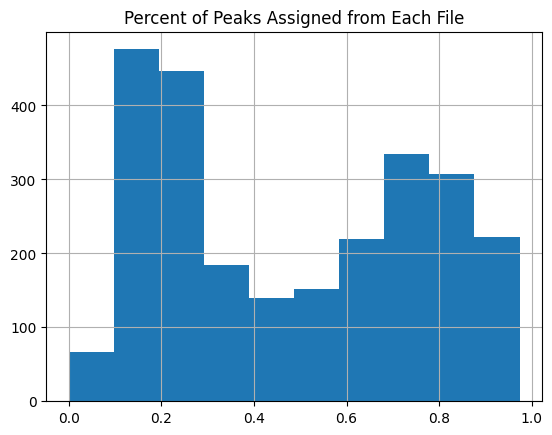

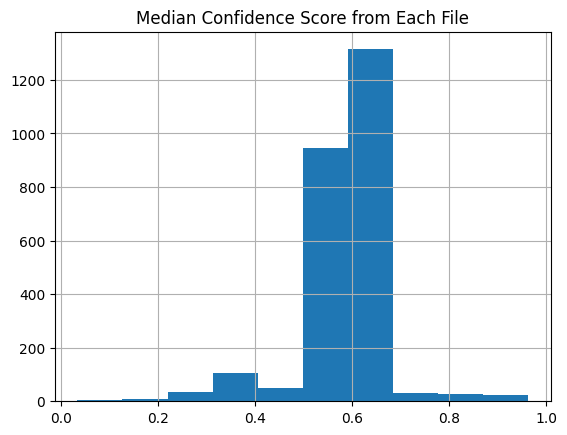

In [25]:

qc_summary.hist("assigned_perc")
plt.title('Percent of Peaks Assigned from Each File')
plt.show()

qc_summary.hist("median_cs")
plt.title('Median Confidence Score from Each File')
plt.show()


### Perform quality control filtering of data sets

Filter to high quality nom data sets with an assigned peak percentage higher than 30%

In [26]:
qc_filt=qc_summary[qc_summary['assigned_perc']>0.30]

Check the number of data sets in each sample type.

In [27]:
qc_filt_counts=qc_filt.value_counts('sample_type')
qc_filt_counts

sample_type
soil        1388
sediment     122
water         33
Name: count, dtype: int64

Randomly sample 30 data sets from each sample type to create more manageable visualizations.

In [28]:
#list of sample types
sample_types=qc_filt_counts.index.tolist()

#for each sample type, randomly sample 30 data sets and save them into list
qc_filt_sample=[]
for type in sample_types:
    qc_type=qc_filt[qc_filt['sample_type']==type]
    qc_type=qc_type.sample(n=30, random_state=2)
    qc_filt_sample.append(qc_type)

#resave list as dataframe
qc_filt_sample=pd.concat(qc_filt_sample)
qc_filt_sample

,biosample,processed,sample_type,url,median_cs,unassigned,assigned,assigned_perc,mol_formulas
1524,nmdc:bsm-11-n95pbc41,nmdc:dobj-11-8n2sf788,soil,https://nmdcdemo.emsl.pnnl.gov/nom/1000soils/r...,0.599988,2035,5849,0.741882,"[C6 H10 O3, C6 H12 O3, C8 H8 O2, C7 H6 O3, C7 ..."
287,nmdc:bsm-11-3d7gwr49,nmdc:dobj-13-sa2mc634,soil,https://nmdcdemo.emsl.pnnl.gov/nom/results/Bro...,0.597315,99,251,0.717143,"[C14 H22 O2, C7 H12 O6 S1, C10 H13 O3 S1 N1, C..."
1536,nmdc:bsm-11-nf4e6z46,nmdc:dobj-11-m09qzx26,soil,https://nmdcdemo.emsl.pnnl.gov/nom/grow/result...,0.856765,621,2047,0.767241,"[C56 H101 O7 N1, C58 H106 O4 S1, C61 H102 O2 S..."
1498,nmdc:bsm-11-n0cjbs26,nmdc:dobj-11-aptz6b94,soil,https://nmdcdemo.emsl.pnnl.gov/nom/1000soils/r...,0.599967,198,1947,0.907692,"[C6 H10 O3, C7 H6 O3, C8 H8 O3, C7 H6 O4, C7 H..."
1035,nmdc:bsm-11-fdjmge85,nmdc:dobj-13-ykh2yk18,soil,https://nmdcdemo.emsl.pnnl.gov/nom/results/Bro...,0.598977,24,281,0.921311,"[C14 H28 O2, C15 H22 O2, C14 H22 O2 13C1, C13 ..."
...,...,...,...,...,...,...,...,...,...
2006,nmdc:bsm-11-vhqj7q61,nmdc:dobj-11-s4zv7t24,water,https://nmdcdemo.emsl.pnnl.gov/nom/grow/result...,0.596122,6939,5427,0.438865,"[C42 H31 O20 S1 N1, C60 H100 O3 S1, C63 H80 O2..."
1963,nmdc:bsm-11-v6herz91,nmdc:dobj-11-ky4x8c12,water,https://nmdcdemo.emsl.pnnl.gov/nom/grow/result...,0.591859,8393,3794,0.311315,"[C45 H27 O20 N1, C58 H76 O8, C40 H68 O22, C45 ..."
1193,nmdc:bsm-11-hnhtzq79,nmdc:dobj-11-3vy77608,water,https://nmdcdemo.emsl.pnnl.gov/nom/grow/result...,0.587863,8999,3964,0.305793,"[C47 H16 O18 S1, C56 H69 O7 S1 N1, C55 H65 O8 ..."
696,nmdc:bsm-11-9rcrwz04,nmdc:dobj-11-v6vzh388,water,https://nmdcdemo.emsl.pnnl.gov/nom/grow/result...,0.598679,1820,2211,0.548499,"[C50 H81 O12 N1, C38 H55 O20 N1, C42 H65 O16 N..."


### Assess presence or absence of molecular formulas from different sample types

Filter to molecular formulas present in a minimum number of data sets

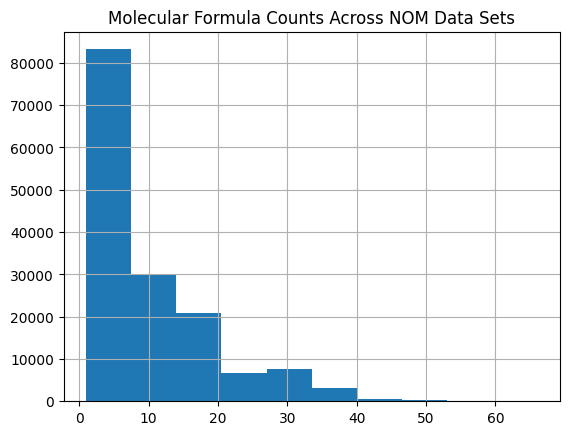

In [38]:
#list all molecular formulas next to the processed nom id in which they were found, dropping nas which came from rows with no assigned molecular formulas
sampled_formulas=qc_filt_sample.explode('mol_formulas').dropna()

#count the number of times each molecular formula appears in all data sets
formula_count=dict(sampled_formulas.value_counts('mol_formulas'))

#copy molecular formulas column
sampled_formulas['formula_count']=sampled_formulas['mol_formulas']

#replace (map) molecular formulas column with the corresponding counts in the dictionary
sampled_formulas['formula_count']=sampled_formulas['formula_count'].map(formula_count)

#histogram of molecular formula counts
sampled_formulas.hist("formula_count")
plt.title('Molecular Formula Counts Across NOM Data Sets')
plt.show()

#based on this histogram, filter to formulas in more than 20 samples
filt_samp_form=sampled_formulas[sampled_formulas['formula_count']>20]

#relist ONLY the chosen formulas present in over 20 samples
group_cols = filt_samp_form.columns.tolist()
group_cols.remove("mol_formulas")
filt_samp_form = filt_samp_form.groupby(group_cols).agg({"mol_formulas": list}).reset_index()

Create heatmap of molecular formulas in the filtered list of processed NOM data object.

/Users/ober845/Library/CloudStorage/OneDrive-PNNL/Desktop/nmdc_notebooks/venv/lib/python3.11/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)
/Users/ober845/Library/CloudStorage/OneDrive-PNNL/Desktop/nmdc_notebooks/venv/lib/python3.11/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


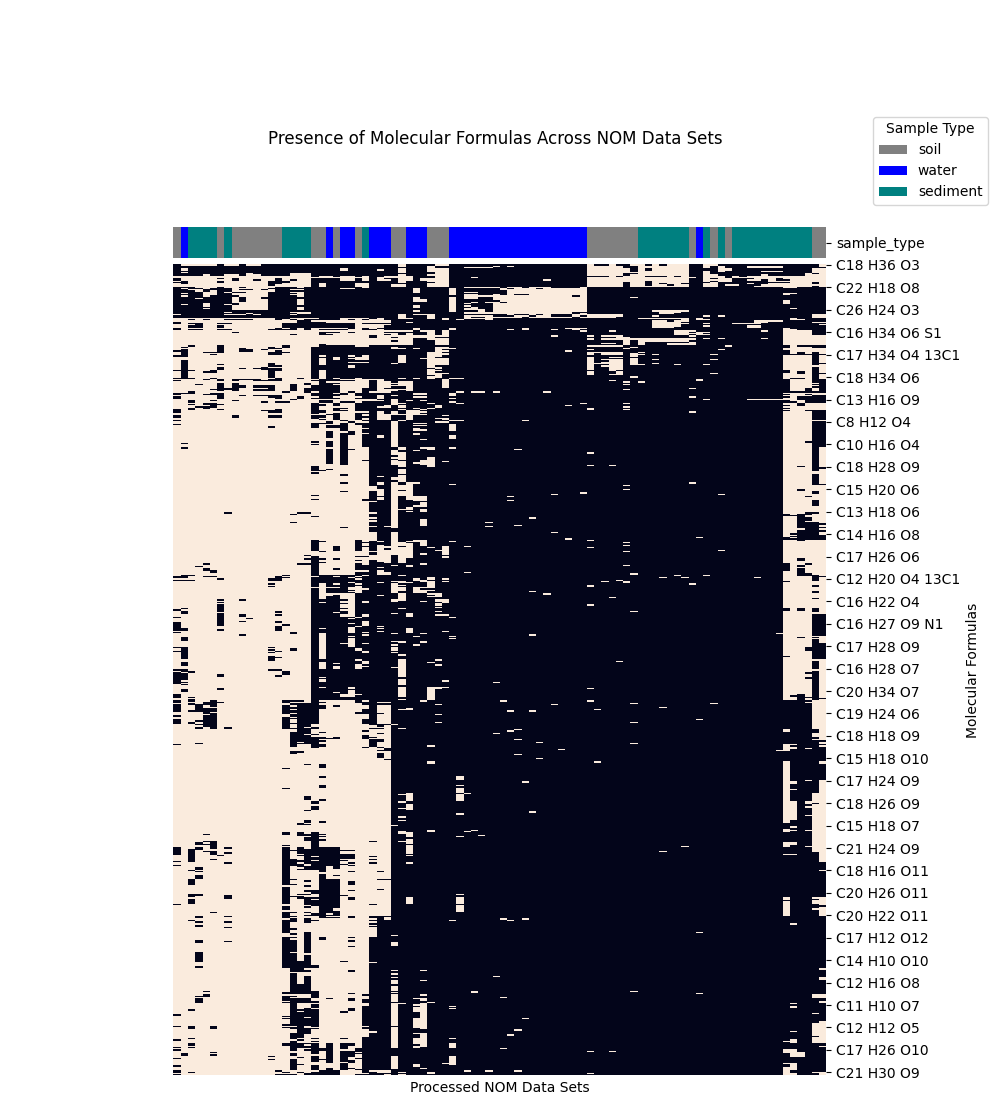

In [39]:
#list all molecular formulas next to the processed nom id in which they were found, dropping nas which came from rows with no molecular formulas matching
formula_nom=filt_samp_form[['processed','sample_type','mol_formulas']].explode('mol_formulas').dropna()

#add column indicating presence in that processed nom id
formula_nom['presence']=1

#set colors for each processed id
type_col=pd.DataFrame({'sample_type':formula_nom['sample_type'].unique(),'color':['grey','b','teal']})
sample_type=formula_nom[['sample_type','processed']].drop_duplicates()
sample_type_col=sample_type.merge(type_col,how='left',on='sample_type').set_index('processed').drop('sample_type',axis=1).rename(columns={'color':'sample_type'})

#create presence/absence matrix
formula_matrix=formula_nom.pivot_table('presence', index='mol_formulas', columns='processed').fillna(0).astype(int)

#setup color legend for sample type
type_col = dict(zip(type_col['sample_type'].unique(), ['grey','b','teal']))
handles = [Patch(facecolor=type_col[name]) for name in type_col]

#heatmap
g=sns.clustermap(data=formula_matrix,col_colors=sample_type_col,tree_kws={"linewidths": 0.},xticklabels=False,cmap='rocket',cbar_pos=None)
g.figure.suptitle("Presence of Molecular Formulas Across NOM Data Sets")
g.ax_heatmap.set_xlabel("Processed NOM Data Sets")
g.ax_heatmap.set_ylabel("Molecular Formulas")
g.figure.subplots_adjust(top=1.1)
plt.legend(handles, type_col, title='Sample Type',
           bbox_to_anchor=(1, 1), bbox_transform=plt.gcf().transFigure)

### Assess molecular composition of different sample types using Van Krevelen plots

Extract molecular formulas, H/C and O/C values from the filtered list of processed NOM data sets.

In [44]:
errors = {}
iteration_counter = 0
output=pd.DataFrame()

for index, row in qc_filt_sample.iterrows():

    iteration_counter += 1

    # print an update for every 45 iterations
    if iteration_counter % 45 == 0:
        print(f"Processed {iteration_counter} rows")
    
    #save data set level information
    url = row["url"]
    biosample = row["biosample"]
    processed=row['processed']
    sample_type=row['sample_type']

    try:
        
        # get csv data for that url
        response = requests.get(url)
        csv_data = StringIO(response.text)
        csv_df = pd.read_csv(csv_data)
        csv_data.close()

        #check if any peaks (m/z) have multiple matches. if so filter to highest scoring match

        #list of peaks
        peak_matches=csv_df["m/z"]
        #list of duplicated peaks in csv_df
        dup_peaks=peak_matches[peak_matches.duplicated()]
        #if there are duplicate peaks in the df, choose highest confidence score to keep
        if len(dup_peaks) > 0:
            #group df by peak and filter to max confidence score
            idx = csv_df.groupby('m/z')['Confidence Score'].max()
            #merge with original df to filter duplicate peak entries
            csv_df=csv_df.merge(idx,on=['m/z','Confidence Score'])
        
        #save processed ID, sample type, and all formula, H/C and O/C for graphing
        csv_df=csv_df[['Molecular Formula','H/C','O/C']]
        csv_df=csv_df.dropna(how='all')
        csv_df['processed']=processed
        csv_df['sample_type']=sample_type
        output=pd.concat([output,csv_df])
 
    except Exception as e:
        print(f"An error occurred: {e}")
        errors["biosample_id"] = biosample
        errors["url"] = url
        continue


Processed 45 rows
Processed 90 rows


Create Van Krevelen Plots to compare molecular composition across sample types.

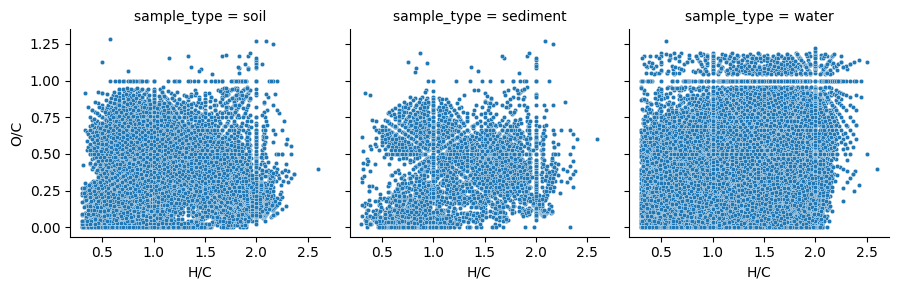

In [48]:
# the same molecular formula will have the same H/C and O/C value in every data set, so dots are only unique on these graphs per sample type
vankrev_data=output[['sample_type','Molecular Formula','H/C','O/C']].drop_duplicates()

#make van krevlen plot
g=sns.FacetGrid(vankrev_data,col="sample_type")
g.map(sns.scatterplot,'H/C','O/C',s=10)

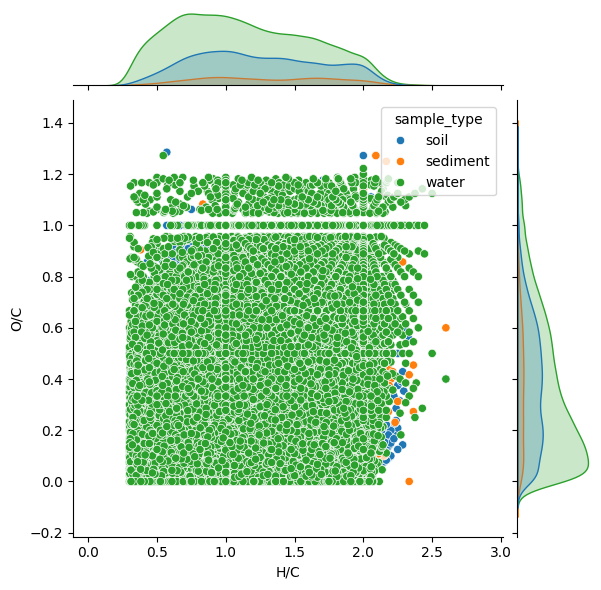

In [55]:
sns.jointplot(data=vankrev_data, x="H/C", y="O/C", kind="scatter", hue="sample_type")
plt.show()